## Importing libraries
---------------

In [152]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import geopandas as gpd

from functools import reduce

## Reading Files
---------------

In [153]:
# Finding CABRa attributes csv files
path_files = pathlib.Path('CABRa_attributes_csv/')
cabra_attributes_files = path_files.rglob('*.csv')

In [154]:
# Reading files
dfs = []
for file in cabra_attributes_files:
    print(file)
    df = pd.read_csv(file, engine='python', delimiter=';')
    dfs.append(df)

CABRa_attributes_csv\CABra_dataset _Additional_attributes.csv
CABRa_attributes_csv\CABra_dataset _Climate_attributes.csv
CABRa_attributes_csv\CABra_dataset_Groundwater_attributes.csv
CABRa_attributes_csv\CABra_dataset_Hydrologic_disturbance_attributes.csv
CABRa_attributes_csv\CABra_dataset_Land_cover_attributes.csv
CABRa_attributes_csv\CABra_dataset_Streamflow_attributes.csv
CABRa_attributes_csv\cabra_general_attributes.csv
CABRa_attributes_csv\cabra_Geology_attributes.csv
CABRa_attributes_csv\CABra_soil_attributes.csv
CABRa_attributes_csv\CABra_topography_attributes.csv


## Creating Dataset and calculating variables
-----------------------

In [155]:
# Merging DataFrames
df_merged = reduce(lambda  left,right: pd.merge(left, right, on=['CABra ID', 'ANA ID'], how='outer'), dfs)

In [156]:
df_merged.head()

,CABra ID,ANA ID,longitude_centroid,latitude_centroid,dist_coast,clim_p,clim_tmin,clim_tmax,clim_rh,clim_wind,...,soil_carbon,soil_bulk,soil_depth,catch_area,elev_mean,elev_min,elev_max,elev_gauge,catch_slope,catch_order
0,1,13880000,-68.028,-8.989,1407.55,5.64,21.61,30.48,83.17,0.82,...,34.439,25.456,1.335,243.410.279,178.97,44.65,564.03,44.65,3.14,7
1,2,14110000,-66.695,2.016,1009.09,8.88,21.83,28.60,86.41,0.42,...,21.926,17.609,1.256,76.898.617,222.97,80.40,2892.44,80.40,4.72,6
2,3,14230000,-68.936,1.573,1009.70,8.52,22.18,29.67,85.71,0.60,...,23.241,20.530,1.219,24.018.785,151.47,80.86,952.20,80.86,2.81,4
3,4,14250000,-67.305,1.734,1095.42,8.86,22.00,29.13,86.26,0.49,...,22.725,18.612,1.235,127.540.913,184.31,74.32,2892.44,74.32,3.71,6
4,5,14260000,-70.894,1.201,964.52,7.79,21.91,28.80,85.44,0.67,...,22.066,20.859,1.248,41.762.638,206.08,85.09,615.36,85.09,2.30,5


In [157]:
# All CABRa attributes files
df_merged.columns

Index(['CABra ID', 'ANA ID', 'longitude_centroid', 'latitude_centroid',
       'dist_coast', 'clim_p', 'clim_tmin', 'clim_tmax', 'clim_rh',
       'clim_wind', 'clim_srad', 'clim_et', 'clim_pet', 'aridity_index',
       'p_seasonality', 'clim_quality', 'aquif_name', 'aquif_type',
       'catch_wtd', 'catch_hand', 'hand_class', 'dist_urban', 'cover_urban_x',
       'cover_crops_x', 'res_number', 'res_area', 'res_volume',
       'res_regulation', 'water_demand', 'hdisturb_index', 'cover_main',
       'cover_bare', 'cover_forest', 'cover_crops_y', 'cover_grass',
       'cover_moss', 'cover_shrub', 'cover_urban_y', 'cover_snow',
       'cover_waterp', 'cover_waters', 'ndvi_djf', 'ndvi_mam', 'ndvi_jja',
       'ndvi_son', 'q_mean', 'q_1', 'q_5', 'q_95', 'q_99', 'q_lf', 'q_ld',
       'q_hf', 'q_hd', 'q_hfd', 'q_zero', 'q_cv', 'q_lcv', 'q_hcv',
       'q_elasticity', 'fdc_slope', 'baseflow_index', 'runoff_coef',
       'longitude', 'latitude', 'gauge_hreg', 'gauge_biome', 'gauge_state',
    

In [158]:
# Calculating ECI (Liu et al. (2020))
# Aparently there is a Warning
df_merged['ECI'] = np.log(df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et']))

C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [159]:
# There is one bad ID
# log(0) => Erro
df_merged.loc[df_merged['ECI'].isnull(),['ECI', 'q_mean', 'clim_p', 'clim_et']]

,ECI,q_mean,clim_p,clim_et
686,NaN,0.03,1.64,1.66


In [160]:
# Calculating the ratio Effective Area / Topographic Area (Liu et al. (2020))
df_merged['Aeff/Atopo'] = df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et'])

In [161]:
# Checking ECI and Ratio
df_merged[['Aeff/Atopo','ECI']].describe()

,Aeff/Atopo,ECI
count,735.000000,734.000000
mean,1.033062,-0.057251
std,0.472764,0.461552
min,-1.500000,-2.277267
25%,0.812509,-0.205516
50%,1.006250,0.006505
75%,1.196199,0.179199
max,6.781955,1.914265


In [162]:
# Creating new column called 'substantial' and grouping into 3 groups
# The ratio is according to Liu et al. (2020)
max_ratio = 2
min_ratio = 0.5

df_merged.loc[df_merged['Aeff/Atopo']>=max_ratio, 'substantial'] = 'gaining'
df_merged.loc[(df_merged['Aeff/Atopo']<max_ratio)&
              (df_merged['Aeff/Atopo']>1), 'substantial'] = 'na'
df_merged.loc[(df_merged['Aeff/Atopo']>min_ratio)&
              (df_merged['Aeff/Atopo']<=1), 'substantial'] = 'na'
df_merged.loc[df_merged['Aeff/Atopo']<=min_ratio, 'substantial'] = 'losing'

In [163]:
# The column 'catch_area' is problematic, because it was a object type.
# Changed to 'int'
df_merged['catch_area'] = df_merged['catch_area'].str.replace('.','')
df_merged['catch_area'] = df_merged['catch_area'].astype('int64')

In [164]:
# List of relevant variables
variables = ['aridity_index', 'catch_area','catch_slope','sub_permeability','elev_mean', 'dist_coast','res_area']

In [165]:
# Checking the variables
df_merged[variables].describe()

,aridity_index,catch_area,catch_slope,sub_permeability,elev_mean,dist_coast,res_area
count,735.000000,7.350000e+02,735.000000,735.000000,735.000000,735.000000,735.000000
mean,1.382517,4.482785e+07,11.661061,-13.439937,672.380694,362.882014,0.283782
std,0.562587,2.385873e+08,7.482936,0.580853,290.669305,325.772133,0.513944
min,0.550000,8.553000e+03,0.670000,-15.645000,47.790000,3.020000,0.000000
25%,1.000000,8.508350e+05,5.780000,-13.810500,461.485000,102.375000,0.020000
50%,1.250000,2.886341e+06,9.230000,-13.328000,695.290000,265.700000,0.090000
75%,1.510000,1.281423e+07,17.250000,-13.000000,863.635000,522.110000,0.275000
max,4.190000,4.807564e+09,35.560000,-12.243000,1718.580000,1472.920000,5.560000


## Plotting
-----------------------

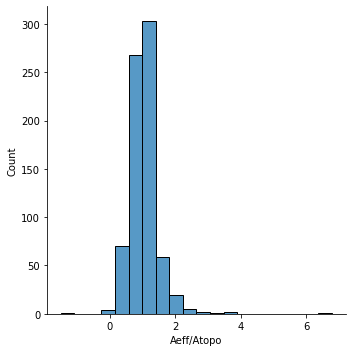

In [166]:
# Checking the distribution of the ratio
# Apparently there is at least one catchment with strange ratios (need to investigate)
sns.displot(df_merged, x='Aeff/Atopo', bins=20)

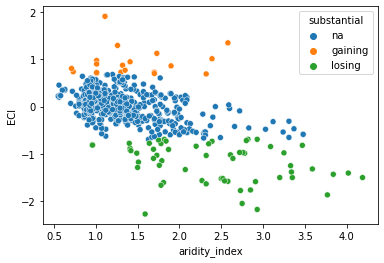

In [167]:
# Scatter plots
sns.scatterplot(x='aridity_index', y='ECI', hue='substantial',data=df_merged)

(10.0, 10000000.0)

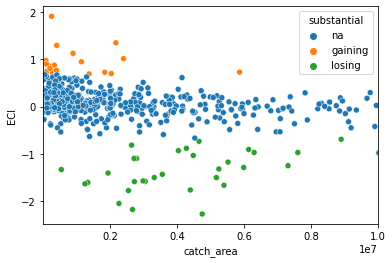

In [168]:
# The graph will deform depending on the xlim you set.
sns.scatterplot(x='catch_area', y='ECI', hue='substantial', data=df_merged)
plt.xlim((1e1,1e7))

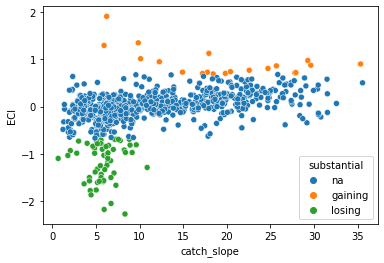

In [169]:
sns.scatterplot(x='catch_slope', y='ECI', hue='substantial', data=df_merged)

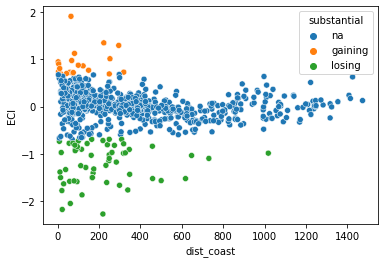

In [170]:
sns.scatterplot(x='dist_coast', y='ECI', hue='substantial', data=df_merged)

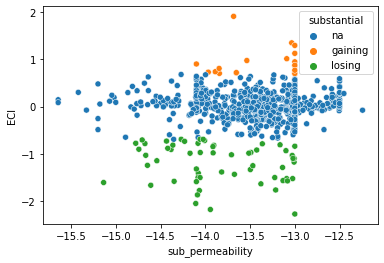

In [171]:
sns.scatterplot(x='sub_permeability', y='ECI', hue='substantial', data=df_merged)

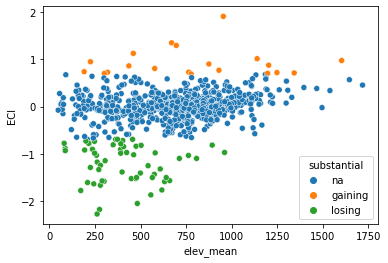

In [172]:
sns.scatterplot(x='elev_mean', y='ECI', hue='substantial', data=df_merged)

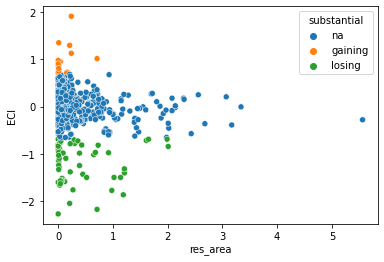

In [173]:
sns.scatterplot(x='res_area', y='ECI', hue='substantial', data=df_merged)

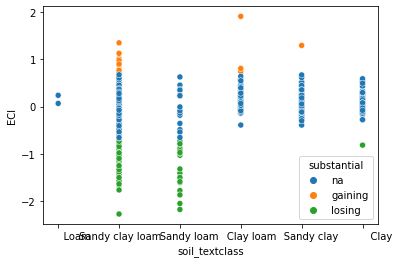

In [174]:
sns.scatterplot(x='soil_textclass', y='ECI', hue='substantial', data=df_merged)

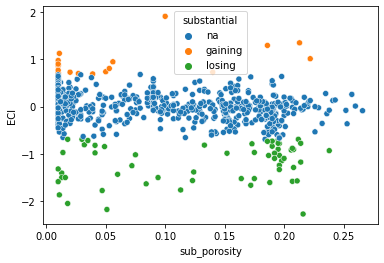

In [175]:
sns.scatterplot(x='sub_porosity', y='ECI', hue='substantial', data=df_merged)

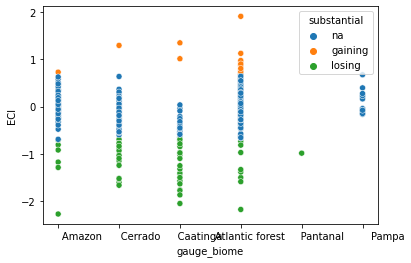

In [176]:
sns.scatterplot(x='gauge_biome', y='ECI', hue='substantial', data=df_merged)

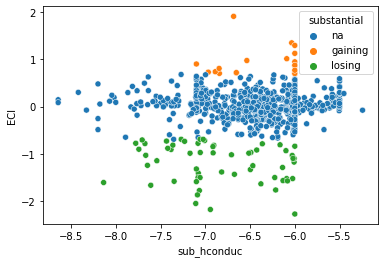

In [177]:
sns.scatterplot(x='sub_hconduc', y='ECI', hue='substantial', data=df_merged)

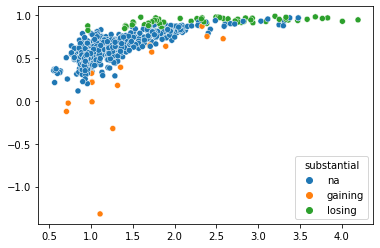

In [178]:
# Budyko scatter plots
# Add lines
sns.scatterplot(x=df_merged['clim_pet']/df_merged['clim_p'], y=(df_merged['clim_p']-df_merged['q_mean'])/df_merged['clim_p'], hue='substantial', data=df_merged)

## Random Forest Analysis
----------------

In [179]:
# We need to drop NaN values before performing Random Forest
df_merged.dropna(subset=variables+['ECI'], inplace=True)

In [180]:
df_merged[variables].head()

,aridity_index,catch_area,catch_slope,sub_permeability,elev_mean,dist_coast,res_area
0,0.89,243410279,3.14,-14.306,178.97,1407.55,0.0
1,0.56,76898617,4.72,-13.883,222.97,1009.09,0.0
2,0.56,24018785,2.81,-13.413,151.47,1009.70,0.0
3,0.55,127540913,3.71,-13.679,184.31,1095.42,0.0
4,0.63,41762638,2.30,-14.073,206.08,964.52,0.0


In [181]:
# Random Forest Classifier
# X: list of variables
# y: 'substantial' column
rfc = RandomForestClassifier(random_state=2)
rfc.fit(X=df_merged[variables], y=df_merged['substantial'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [182]:
# Checking variables that it is considered importante according to the Random Forest Classifier
rfc.feature_importances_

array([0.30986546, 0.09140674, 0.13083014, 0.11454665, 0.13906451,
       0.14277733, 0.07150917])

In [183]:
# Random Forest Classifier
# X: list of variables
# y: 'ECI' values
rfr = RandomForestRegressor(random_state=2)
rfr.fit(X=df_merged[variables], y=df_merged['ECI'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [184]:
# Checking variables that it is considered importante according to the Random Forest Regressor
rfr.feature_importances_

array([0.41325223, 0.08905777, 0.22361404, 0.04431343, 0.10210944,
       0.08029076, 0.04736232])

In [185]:
# Checking zipped results
for i, c, r in zip(variables, rfc.feature_importances_, rfr.feature_importances_):
    print(f'{i}: RFC: {c:.3f} | RFR: {r:.3f}')

aridity_index: RFC: 0.310 | RFR: 0.413
catch_area: RFC: 0.091 | RFR: 0.089
catch_slope: RFC: 0.131 | RFR: 0.224
sub_permeability: RFC: 0.115 | RFR: 0.044
elev_mean: RFC: 0.139 | RFR: 0.102
dist_coast: RFC: 0.143 | RFR: 0.080
res_area: RFC: 0.072 | RFR: 0.047


## Map plot
------------------

In [186]:
# Creading GeoDataFrame
gdf = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged['longitude_centroid'], df_merged['latitude_centroid']))

In [187]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

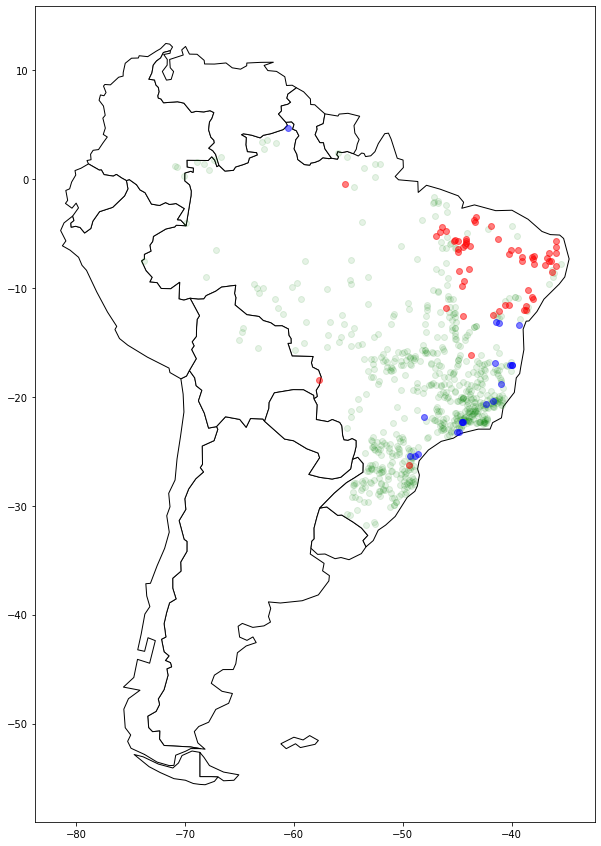

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
world[world.continent == 'South America'].plot(color='white', edgecolor='black', ax=ax)

gdf.loc[gdf['substantial']=='na'].plot(color='green', ax=ax,alpha=0.1)
gdf.loc[gdf['substantial']=='gaining'].plot(color='blue', ax=ax, alpha=0.5)
gdf.loc[gdf['substantial']=='losing'].plot(color='red', ax=ax, alpha=0.5)

plt.show()